In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

In [2]:
with open("vggface16.tfmodel", mode='rb') as f:
  fileContent = f.read()

graph_def = tf.GraphDef()
graph_def.ParseFromString(fileContent)
images = tf.placeholder(tf.float32, [None, 224, 224, 3])
# put the graph to default_graph

#with tf.device("/job:local/task:1"):
with tf.device("/job:worker"):
    tf.import_graph_def(graph_def, input_map={ "images": images })
print "graph loaded from disk"

graph loaded from disk


In [3]:
graph = tf.get_default_graph()
train_writer = tf.summary.FileWriter('/tmp/loser1/train',graph)

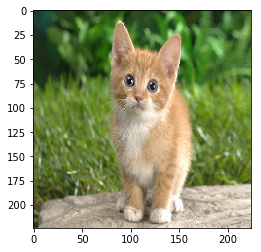

In [4]:
# imread a image
cat=cv2.imread("cat.jpg")
cat=cv2.cvtColor(cat, cv2.COLOR_BGR2RGB)
cat=cv2.resize(cat,(224, 224))
plt.imshow(cat)

In [5]:
with tf.Session("grpc://localhost:2222") as sess:
    init = tf.initialize_all_variables()
    sess.run(init)
    print "variables initialized"

    batch = cat.reshape((1, 224, 224, 3))
    assert batch.shape == (1, 224, 224, 3)

    feed_dict = { images: batch }

    prob_tensor = graph.get_tensor_by_name("import/prob:0")
    prob = sess.run(prob_tensor, feed_dict=feed_dict)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
variables initialized


# [sec2] forward faces to pool5


In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

In [2]:
import numpy as np
frames=np.load("whimh2.0/outfile_x.npy")
y_train=np.load("whimh2.0/outfile_y.npy").astype(int)

In [3]:
with open("vggface16.tfmodel", mode='rb') as f:
  fileContent = f.read()

graph_def = tf.GraphDef()
graph_def.ParseFromString(fileContent)
with tf.device("/job:worker"):
    x_tf = tf.placeholder(tf.float32, shape=[None, 32,32,3],name="raw_images_mh")
    x_tf_1=tf.image.resize_images(x_tf,[224,224])
    
    tf.import_graph_def(graph_def, input_map={ "images": x_tf_1 })
    
    
graph = tf.get_default_graph()
feature_net=graph.get_tensor_by_name("import/pool5:0")



In [4]:
with tf.Session("grpc://localhost:2222") as sess:
    init = tf.initialize_all_variables()
    sess.run(init)
    feature_x1 = sess.run([feature_net], feed_dict={x_tf:frames[:100]})[0]
    feature_x2 = sess.run([feature_net], feed_dict={x_tf:frames[100:200]})[0]
    feature_x3 = sess.run([feature_net], feed_dict={x_tf:frames[200:300]})[0]
    feature_x4 = sess.run([feature_net], feed_dict={x_tf:frames[300:400]})[0]
    feature_x5 = sess.run([feature_net], feed_dict={x_tf:frames[400:500]})[0]
    feature_x6 = sess.run([feature_net], feed_dict={x_tf:frames[500:600]})[0]
    feature_x7 = sess.run([feature_net], feed_dict={x_tf:frames[600:700]})[0]
    feature_x8 = sess.run([feature_net], feed_dict={x_tf:frames[700:800]})[0]
    feature_x9 = sess.run([feature_net], feed_dict={x_tf:frames[800:900]})[0]
    feature_x10 = sess.run([feature_net], feed_dict={x_tf:frames[900:]})[0]

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [5]:
feature_x=(np.concatenate((feature_x1, feature_x2, feature_x3,
                    feature_x4, feature_x5, feature_x6,
                    feature_x7, feature_x8, feature_x9,
                    feature_x10), axis=0))
print feature_x.shape

(959, 7, 7, 512)


In [6]:
np.save("finetune_X",feature_x)

# [sec2.5] train models for fc 

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np

%matplotlib inline

In [2]:
feature_x=np.load("finetune_X.npy")
frames=np.load("whimh2.0/outfile_x.npy")
y_train=np.load("whimh2.0/outfile_y.npy").astype(int)

In [3]:
arr = np.arange(len(feature_x))
np.random.shuffle(arr)
x_train=feature_x[arr]
frames=frames[arr]
#x_train=norm2[arr]
y_train=y_train[arr]
data={
  'X_train': x_train[:int(len(x_train)*0.8)],
  'y_train': y_train[:int(len(x_train)*0.8)],
  'X_val': x_train[int(len(x_train)*0.8):],
  'y_val': y_train[int(len(x_train)*0.8):],
  'X_val_frame' : frames[int(len(x_train)*0.8):],
}
print "there are "+ str(data['X_train'].shape[0]) + " images in training set"
print "there are "+ str(data['X_val'].shape[0]) + " images in testing set"

there are 767 images in training set
there are 192 images in testing set


In [4]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.0001)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.01, shape=shape)
  return tf.Variable(initial)

In [5]:
#x_tfed = tf.placeholder(tf.float32, shape=[None,2,2,512],name='feature_x')
x_tfed = tf.placeholder(tf.float32, shape=[None,7,7,512],name='feature_x')
y_tf = tf.placeholder(tf.int32, shape=[None,],name='truth_y')

In [6]:
#Here contains the finetune layers
with tf.device("/job:worker/task:1"):
    with tf.name_scope('fintune_whimh'):

        y_tf_2=tf.one_hot(y_tf,3)

        with tf.name_scope('finetune_layer'):
            #calculate_entropy
            #h_pool3_flat = tf.reshape(x_tfed, [-1, 2*2*512])
            h_pool3_flat = tf.reshape(x_tfed, [-1, 7*7*512])

            W_whimh_fc1 = weight_variable([7*7*512,1024])
            #W_whimh_fc1 = weight_variable([2*2*512, 1024])
            b_whimh_fc1 = bias_variable([1024])
            h_fc1=tf.nn.relu(tf.matmul(h_pool3_flat, W_whimh_fc1) + b_whimh_fc1) 

        with tf.name_scope('finetune_layer'):
            #calculate_entropy
            W_whimh_fc2 = weight_variable([1024, 3])
            b_whimh_fc2 = bias_variable([3])
            y_conv=tf.nn.softmax(tf.matmul(h_fc1, W_whimh_fc2) + b_whimh_fc2, name='predictions_softmax') 

        with tf.name_scope('loss_calulate'):
            #calculate_entropy
            cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_tf_2 * tf.log(y_conv), reduction_indices=[1]))
        with tf.name_scope('regular'):    
            regularizers = (tf.nn.l2_loss(W_whimh_fc1) + tf.nn.l2_loss(b_whimh_fc1)+
                            (tf.nn.l2_loss(W_whimh_fc2) + tf.nn.l2_loss(b_whimh_fc2))
                           )

        with tf.name_scope('loss'):
            #carefully deal overfitting
            loss=cross_entropy+1e-1*regularizers
        with tf.name_scope('slover'):
            train_step = tf.train.AdamOptimizer(1e-6).minimize(loss)

        with tf.name_scope('measure'):
            with tf.name_scope('predict'):
                predctions=tf.argmax(y_conv,1, name='predictions_')
            with tf.name_scope('groundtruth'):
                ground_truth=tf.argmax(y_tf_2,1)
            correct_prediction = tf.equal(predctions, ground_truth)
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

            #MHaccuracy
            idxsMH = tf.where(tf.equal(ground_truth, 0))
            correct_predictionMH = tf.equal(tf.argmax(tf.gather(y_conv,idxsMH),2), tf.argmax(tf.gather(y_tf_2,idxsMH),2))
            accuracyMH = tf.reduce_mean(tf.cast(correct_predictionMH, tf.float32))
            #NMaccuracy
            idxsNM = tf.where(tf.equal(ground_truth, 1))
            correct_predictionNM = tf.equal(tf.argmax(tf.gather(y_conv,idxsNM),2), tf.argmax(tf.gather(y_tf_2,idxsNM),2))
            accuracyNM = tf.reduce_mean(tf.cast(correct_predictionNM, tf.float32))
            #NHaccuracy
            idxsNH = tf.where(tf.equal(ground_truth, 2))
            correct_predictionNH = tf.equal(tf.argmax(tf.gather(y_conv,idxsNH),2), tf.argmax(tf.gather(y_tf_2,idxsNH),2))
            accuracyNH = tf.reduce_mean(tf.cast(correct_predictionNH, tf.float32))

        tf.summary.scalar('accuracy', accuracy)
        tf.summary.scalar('accuracyMH', accuracyMH)
        tf.summary.scalar('accuracyNM', accuracyNM)
        tf.summary.scalar('accuracyNH', accuracyNH)
        #this variable means records all records
        merged = tf.summary.merge_all()


In [7]:
graph = tf.get_default_graph()


In [8]:
train_writer = tf.summary.FileWriter('/tmp/loser3/train',graph)
test_writer = tf.summary.FileWriter('/tmp/loser3/test')

In [9]:
with tf.Session("grpc://localhost:2222") as sess:
#with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    k=0
    for i in range(500):
      arr=np.arange(len(data['X_train']))
      np.random.shuffle(arr)
      idx = arr[:5]
      train_step.run(feed_dict={x_tfed:data['X_train'][idx], y_tf: data['y_train'][idx]})
      if i%10==0:
        ############training acc###########
        #train_accuracy = accuracy.eval(feed_dict={   
        #x_tf:data['X_train'], y_tf: data['y_train'], keep_prob: 1.0})
        summary, train_accuracy = sess.run([merged, accuracy], feed_dict={   
                x_tfed:data['X_train'], y_tf: data['y_train']})
        train_writer.add_summary(summary, i)
        ############testing acc#########
        #testing_accuracy = accuracy.eval(feed_dict={   
        #x_tf:data['X_val'], y_tf: data['y_val'], keep_prob: 1.0})

        summary, testing_accuracy = sess.run([merged, accuracy], feed_dict={   
                x_tfed:data['X_val'], y_tf: data['y_val']})
        test_writer.add_summary(summary, i)
        print("step %d, training accur1acy %g, testing acc %g"%(i, train_accuracy,testing_accuracy))
    


Instructions for updating:
Use `tf.global_variables_initializer` instead.
step 0, training accur1acy 0.546284, testing acc 0.59375
step 10, training accur1acy 0.640156, testing acc 0.677083
step 20, training accur1acy 0.873533, testing acc 0.911458
step 30, training accur1acy 0.946545, testing acc 0.96875
step 40, training accur1acy 0.916558, testing acc 0.942708
step 50, training accur1acy 0.902216, testing acc 0.932292
step 60, training accur1acy 0.925685, testing acc 0.947917
step 70, training accur1acy 0.925685, testing acc 0.942708
step 80, training accur1acy 0.924381, testing acc 0.947917
step 90, training accur1acy 0.966102, testing acc 0.973958
step 100, training accur1acy 0.968709, testing acc 0.963542
step 110, training accur1acy 0.96219, testing acc 0.96875
step 120, training accur1acy 0.967405, testing acc 0.963542
step 130, training accur1acy 0.964798, testing acc 0.96875
step 140, training accur1acy 0.964798, testing acc 0.958333
step 150, training accur1acy 0.958279, tes

In [10]:
#overall
with tf.Session("grpc://localhost:2222") as sess:
    print("test accuracy %g"%accuracy.eval(feed_dict={
    x_tfed:data['X_val'], y_tf: data['y_val']}))

test accuracy 0.979167


In [11]:
# resotre data for freeze
with tf.Session("grpc://localhost:2222") as sess:
    saver = tf.train.Saver()
    saver.save(sess, 'chkpt', global_step=0, latest_filename='chkpt_state')
tf.train.write_graph(sess.graph.as_graph_def(),"/home/stream/Documents/distribute_tf", 'pretensorWhimh.pb', False)

'/home/stream/Documents/distribute_tf/pretensorWhimh.pb'

# [sec3] freeze the graph (need to reboot session)

In [1]:
from freeze_graph import freeze_graph

In [2]:
input_saver_def_path = ''
input_binary=True
input_checkpoint_path = './chkpt-0'
input_graph_path = 'pretensorWhimh.pb'
output_graph_path = 'pretensorWhimh.pb'
output_node_names = 'fintune_whimh/measure/predict/predictions_'
restore_op_name = "save/restore_all"
filename_tensor_name = "save/Const:0"
clear_devices = True

freeze_graph(input_graph_path, input_saver_def_path,
                              input_binary, input_checkpoint_path,
                              output_node_names, restore_op_name,
                              filename_tensor_name, output_graph_path,
                              clear_devices, "")



/job:worker/task:1
/job:worker/task:1
/job:worker/task:1
/job:worker/task:1
/job:worker/task:1
/job:worker/task:1
/job:worker/task:1
/job:worker/task:1
/job:worker/task:1
/job:worker/task:1
/job:worker/task:1
/job:worker/task:1
/job:worker/task:1
/job:worker/task:1
/job:worker/task:1
/job:worker/task:1
/job:worker/task:1
/job:worker/task:1
/job:worker/task:1
/job:worker/task:1
/job:worker/task:1
/job:worker/task:1
/job:worker/task:1
/job:worker/task:1
/job:worker/task:1
/job:worker/task:1
/job:worker/task:1
/job:worker/task:1
/job:worker/task:1
/job:worker/task:1
/job:worker/task:1
/job:worker/task:1
/job:worker/task:1
/job:worker/task:1
/job:worker/task:1
/job:worker/task:1
/job:worker/task:1
/job:worker/task:1
/job:worker/task:1
/job:worker/task:1
/job:worker/task:1
/job:worker/task:1
/job:worker/task:1
/job:worker/task:1
/job:worker/task:1
/job:worker/task:1
/job:worker/task:1
/job:worker/task:1
/job:worker/task:1
/job:worker/task:1
/job:worker/task:1
/job:worker/task:1
/job:worke

# [sec4] concate two freezed graph

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
with tf.device("/job:worker/task:0"):
    x_tf = tf.placeholder(tf.float32, shape=[None, 32,32,3],name="raw_images_mh")
    x_tf_1=tf.image.resize_images(x_tf,[224,224])
    y_tf = tf.placeholder(tf.int32, shape=[None,],name="turth_y_mh")

In [2]:
with open("pretensorWhimh.pb", mode='rb') as f:
  fileContent = f.read()
gdef_1 = tf.GraphDef()
gdef_1.ParseFromString(fileContent)


102779279

In [3]:
## fucking awesome , learned from freezen_graph
for node in gdef_1.node:
    node.device="/job:worker/task:1"

In [4]:
with open("vggface16.tfmodel", mode='rb') as f:
  fileContent = f.read()
gdef_2 = tf.GraphDef()
gdef_2.ParseFromString(fileContent)

580019954

In [5]:
## fucking awesome , learned from freezen_graph
for node in gdef_2.node:
    node.device="/job:worker/task:0"

In [6]:
for node in gdef_2.node:
    if "conv5" in node.name or "pool5" in node.name:
        node.device="/job:worker/task:1"
    if "conv4" in node.name or "pool4" in node.name:
        node.device="/job:worker/task:1"
    if "conv3" in node.name or "pool3" in node.name:
        node.device="/job:worker/task:1"

In [7]:
with tf.Graph().as_default() as g_combined:
        feature_x=tf.import_graph_def(gdef_2, input_map={ "images": x_tf_1 },return_elements=["pool5:0"],name="vgg")
        results=tf.import_graph_def(gdef_1, input_map={ "feature_x:0": feature_x[0]},return_elements=["fintune_whimh/measure/predict/predictions_:0"])

In [8]:
graph = tf.get_default_graph()

In [9]:
train_writer = tf.summary.FileWriter('/tmp/loser3/train',graph)

In [10]:
frames=np.load("whimh2.0/outfile_x.npy")
y_train=np.load("whimh2.0/outfile_y.npy").astype(int)

In [11]:
arr = np.arange(len(frames))
np.random.shuffle(arr)
print y_train[arr[0:10]]
sess=tf.Session("grpc://invpm30:2222",config=tf.ConfigProto(log_device_placement=True))
w=sess.run(results, feed_dict={x_tf:frames[arr[0:100]]})

[2 1 1 1 1 2 2 1 2 1]


In [12]:
w

[array([2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 0, 1, 1, 2, 1, 2,
        1, 1, 1, 2, 1, 1, 0, 1, 2, 2, 2, 1, 2, 0, 1, 0, 2, 2, 1, 2, 0, 2, 2,
        1, 1, 1, 1, 0, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1,
        1, 1, 1, 0, 2, 2, 2, 1, 2, 0, 1, 1, 1, 1, 2, 1, 0, 2, 2, 0, 2, 1, 1,
        1, 0, 1, 2, 1, 2, 2, 1])]